In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense
# sns.set_style("whitegrid")
plt.style.use('seaborn')

Using TensorFlow backend.


In [2]:
# base_dir = 'd:/GitHub/python-2-work/' # work
base_dir = 'd:/_SRC_/ensemble-forecasting/'  # home
h = np.loadtxt(base_dir + 'data/2011/2011080100_hiromb_GI_60x434.txt') - 37.356
s = np.loadtxt(base_dir + 'data/2011/2011080100_swan_GI_48x434.txt')
n = np.loadtxt(base_dir + 'data/2011/2011080100_noswan_GI_48x434.txt')
m = np.loadtxt(base_dir + 'data/2011/2011080100_measurements_GI_2623.txt')

# forecast dimensions
N = 100 # 430
T = 48

# preparing measurements forecast
m_fc = np.zeros((N, T+1))
for i in range(N):
    for j in range(T+1):
        m_fc[i, j] = m[i*6+j]

# data cut and shifting
shift_const = 0
h = h[0:N, 1:T+1] + shift_const
s = s[0:N, 1:T+1] + shift_const
n = n[0:N, 1:T+1] + shift_const
m_fc = m_fc[0:N, 1:T+1] + shift_const
h.shape, s.shape, n.shape, m_fc.shape

((100, 48), (100, 48), (100, 48), (100, 48))

In [3]:
a = opt.minimize(lambda a: np.mean(np.abs(a[0] + a[1]*h + a[2]*s - m_fc)), 
                 [0, 0.5, 0.5]).x
ens = a[0] + a[1]*h + a[2]*s        
                 
def plot_ensemble(q):
    plt.figure()
    plt.plot(h[q], 'r-')
    plt.plot(s[q], 'g-')
    plt.plot(m_fc[q], 'ko')
    plt.plot(ens[q], 'm-', linewidth=2)
    plt.title('h:{0:.2f} s:{1:.2f} ens:{2:.2f}'.format(np.mean(np.abs(h[q] - m_fc[q])),
              np.mean(np.abs(s[q] - m_fc[q])), 
              np.mean(np.abs(ens[q] - m_fc[q]))))

a

array([ 4.43583102,  0.60883268,  0.28889466])

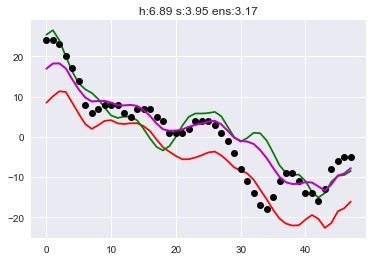

In [4]:
plot_ensemble(50)

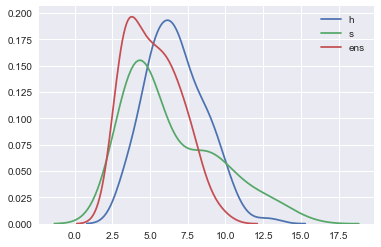

In [5]:
sns.kdeplot(np.mean(np.abs(h - m_fc), axis=1), label='h')
sns.kdeplot(np.mean(np.abs(s - m_fc), axis=1), label='s')
sns.kdeplot(np.mean(np.abs(ens - m_fc), axis=1), label='ens')

# Baseline ANN

In [7]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def baseline_ann_ensemble():
    model = Sequential()
    model.add(Dense(units=2, kernel_initializer='normal', activation='relu', input_dim=2))
    model.add(Dense(units=1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
X = np.vstack((h.flatten(), s.flatten())).transpose()
Y = m_fc.flatten()
seed = 7
np.random.seed(seed)
estimator = KerasRegressor(build_fn=baseline_ann_ensemble, epochs=100, batch_size=10, verbose=0)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: -52.76 (26.59) MSE


In [27]:
estimator.fit(X, Y)
estimator.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 3         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


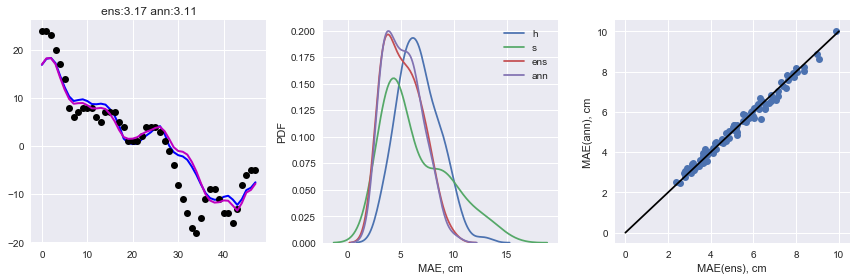

In [52]:
q = 50
predicted = np.array([estimator.predict(np.array([h[q], s[q]]).transpose()) for q in range(N)])
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(predicted[q], 'b-', linewidth=2)
plt.plot(m_fc[q], 'ko')
plt.plot(ens[q], 'm-', linewidth=2)
plt.title('ens:{0:.2f} ann:{1:.2f}'.format(np.mean(np.abs(ens[q] - m_fc[q])), np.mean(np.abs(predicted[q] - m_fc[q]))))
plt.subplot(132)
sns.kdeplot(np.mean(np.abs(h - m_fc), axis=1), label='h')
sns.kdeplot(np.mean(np.abs(s - m_fc), axis=1), label='s')
sns.kdeplot(np.mean(np.abs(ens - m_fc), axis=1), label='ens')
sns.kdeplot(np.mean(np.abs(predicted - m_fc), axis=1), label='ann')
plt.xlabel('MAE, cm')
plt.ylabel('PDF')
plt.subplot(133)
plt.plot(np.mean(np.abs(ens - m_fc), axis=1), np.mean(np.abs(predicted - m_fc), axis=1), 'o')
plt.plot([0,10], [0,10], 'k-')
plt.xlabel('MAE(ens), cm')
plt.ylabel('MAE(ann), cm')
plt.tight_layout()

## Standartize

In [47]:
np.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_ann_ensemble, epochs=100, batch_size=10, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -51.39 (26.04) MSE


In [48]:
pipeline.fit(X,Y)

Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('mlp', <keras.wrappers.scikit_learn.KerasRegressor object at 0x000001C3925F9AC8>)])

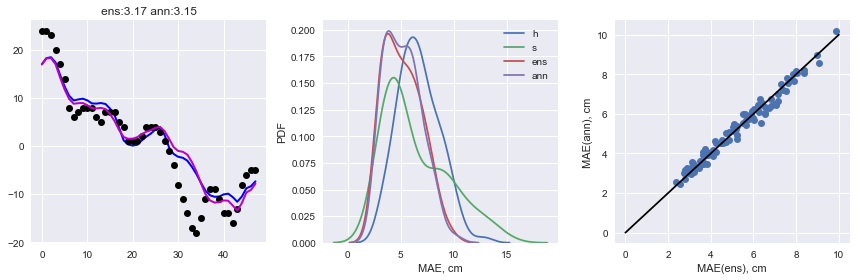

In [53]:
q = 50
predicted = np.array([pipeline.predict(np.array([h[q], s[q]]).transpose()) for q in range(N)])
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(predicted[q], 'b-', linewidth=2)
plt.plot(m_fc[q], 'ko')
plt.plot(ens[q], 'm-', linewidth=2)
plt.title('ens:{0:.2f} ann:{1:.2f}'.format(np.mean(np.abs(ens[q] - m_fc[q])), np.mean(np.abs(predicted[q] - m_fc[q]))))
plt.subplot(132)
sns.kdeplot(np.mean(np.abs(h - m_fc), axis=1), label='h')
sns.kdeplot(np.mean(np.abs(s - m_fc), axis=1), label='s')
sns.kdeplot(np.mean(np.abs(ens - m_fc), axis=1), label='ens')
sns.kdeplot(np.mean(np.abs(predicted - m_fc), axis=1), label='ann')
plt.xlabel('MAE, cm')
plt.ylabel('PDF')
plt.subplot(133)
plt.plot(np.mean(np.abs(ens - m_fc), axis=1), np.mean(np.abs(predicted - m_fc), axis=1), 'o')
plt.plot([0,10], [0,10], 'k-')
plt.xlabel('MAE(ens), cm')
plt.ylabel('MAE(ann), cm')
plt.tight_layout()

# Whole-forecast ensemble

In [31]:
def whole_fc_ann_ensemble():
    model = Sequential()
    model.add(Dense(units=T*2, kernel_initializer='normal', activation='relu', input_dim=T*2))
    model.add(Dense(units=T, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
X = np.hstack((h, s))
Y = m_fc
seed = 7
np.random.seed(seed)
# epochs and batch_size tuned manually
estimator = KerasRegressor(build_fn=whole_fc_ann_ensemble, epochs=15, batch_size=12, verbose=0)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: -51.05 (24.94) MSE


In [32]:
estimator.fit(X, Y)
estimator.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_743 (Dense)            (None, 96)                9312      
_________________________________________________________________
dense_744 (Dense)            (None, 48)                4656      
Total params: 13,968
Trainable params: 13,968
Non-trainable params: 0
_________________________________________________________________


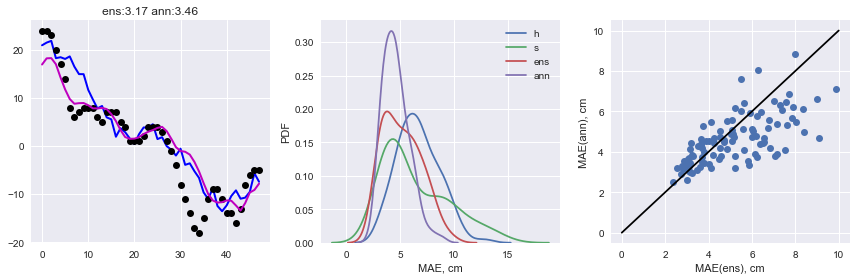

In [36]:
q = 50
predicted = estimator.predict(X)
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(predicted[q], 'b-', linewidth=2, label='ann')
plt.plot(m_fc[q], 'ko')
plt.plot(ens[q], 'm-', linewidth=2, label='ens')
plt.title('ens:{0:.2f} ann:{1:.2f}'.format(np.mean(np.abs(ens[q] - m_fc[q])), np.mean(np.abs(predicted[q] - m_fc[q]))))
plt.subplot(132)
sns.kdeplot(np.mean(np.abs(h - m_fc), axis=1), label='h')
sns.kdeplot(np.mean(np.abs(s - m_fc), axis=1), label='s')
sns.kdeplot(np.mean(np.abs(ens - m_fc), axis=1), label='ens')
sns.kdeplot(np.mean(np.abs(predicted - m_fc), axis=1), label='ann')
plt.xlabel('MAE, cm')
plt.ylabel('PDF')
plt.subplot(133)
plt.plot(np.mean(np.abs(ens - m_fc), axis=1), np.mean(np.abs(predicted - m_fc), axis=1), 'o')
plt.plot([0,10], [0,10], 'k-')
plt.xlabel('MAE(ens), cm')
plt.ylabel('MAE(ann), cm')
plt.tight_layout()

## Deeper network

In [45]:
def whole_fc_ann_ensemble():
    model = Sequential()
    model.add(Dense(units=T*2, kernel_initializer='normal', activation='relu', input_dim=T*2))
    model.add(Dense(units=T, kernel_initializer='normal', activation='relu'))
    model.add(Dense(units=T, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
X = np.hstack((h, s))
Y = m_fc
# for e in range(10,101,10):
# Results (e: 10): -67.10 (46.96) MSE
# Results (e: 20): -56.83 (29.00) MSE
# Results (e: 30): -53.41 (28.03) MSE
# Results (e: 40): -57.66 (31.38) MSE
seed = 7
np.random.seed(seed)
# epochs and batch_size tuned manually
estimator = KerasRegressor(build_fn=whole_fc_ann_ensemble, epochs=30, batch_size=10, verbose=0)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: -53.46 (27.94) MSE


In [46]:
estimator.fit(X, Y)
estimator.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1047 (Dense)           (None, 96)                9312      
_________________________________________________________________
dense_1048 (Dense)           (None, 48)                4656      
_________________________________________________________________
dense_1049 (Dense)           (None, 48)                2352      
Total params: 16,320
Trainable params: 16,320
Non-trainable params: 0
_________________________________________________________________


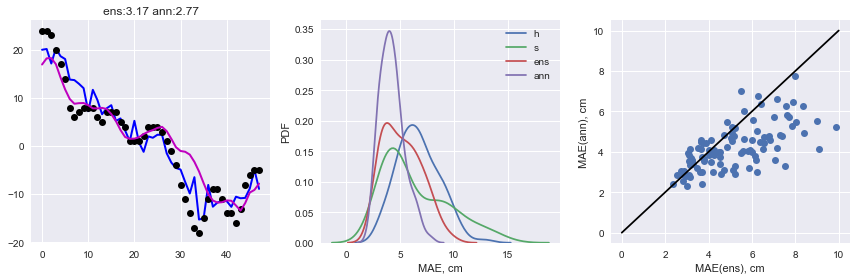

In [47]:
q = 50
predicted = estimator.predict(X)
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(predicted[q], 'b-', linewidth=2, label='ann')
plt.plot(m_fc[q], 'ko')
plt.plot(ens[q], 'm-', linewidth=2, label='ens')
plt.title('ens:{0:.2f} ann:{1:.2f}'.format(np.mean(np.abs(ens[q] - m_fc[q])), np.mean(np.abs(predicted[q] - m_fc[q]))))
plt.subplot(132)
sns.kdeplot(np.mean(np.abs(h - m_fc), axis=1), label='h')
sns.kdeplot(np.mean(np.abs(s - m_fc), axis=1), label='s')
sns.kdeplot(np.mean(np.abs(ens - m_fc), axis=1), label='ens')
sns.kdeplot(np.mean(np.abs(predicted - m_fc), axis=1), label='ann')
plt.xlabel('MAE, cm')
plt.ylabel('PDF')
plt.subplot(133)
plt.plot(np.mean(np.abs(ens - m_fc), axis=1), np.mean(np.abs(predicted - m_fc), axis=1), 'o')
plt.plot([0,10], [0,10], 'k-')
plt.xlabel('MAE(ens), cm')
plt.ylabel('MAE(ann), cm')
plt.tight_layout()

# Wider network

In [48]:
def whole_fc_ann_ensemble():
    model = Sequential()
    model.add(Dense(units=T*4, kernel_initializer='normal', activation='relu', input_dim=T*2))
    model.add(Dense(units=T, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
X = np.hstack((h, s))
Y = m_fc
# for e in range(10,101,10):
# Results (e: 10): -67.10 (46.96) MSE
# Results (e: 20): -56.83 (29.00) MSE
# Results (e: 30): -53.41 (28.03) MSE
# Results (e: 40): -57.66 (31.38) MSE
seed = 7
np.random.seed(seed)
# epochs and batch_size tuned manually
estimator = KerasRegressor(build_fn=whole_fc_ann_ensemble, epochs=20, batch_size=10, verbose=0)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: -52.74 (29.24) MSE


In [49]:
estimator.fit(X, Y)
estimator.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1070 (Dense)           (None, 192)               18624     
_________________________________________________________________
dense_1071 (Dense)           (None, 48)                9264      
Total params: 27,888
Trainable params: 27,888
Non-trainable params: 0
_________________________________________________________________


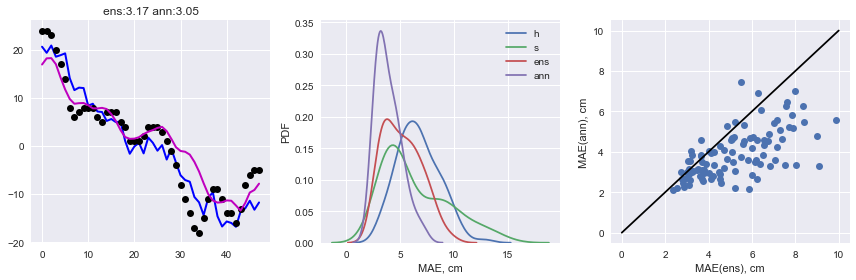

In [50]:
q = 50
predicted = estimator.predict(X)
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(predicted[q], 'b-', linewidth=2, label='ann')
plt.plot(m_fc[q], 'ko')
plt.plot(ens[q], 'm-', linewidth=2, label='ens')
plt.title('ens:{0:.2f} ann:{1:.2f}'.format(np.mean(np.abs(ens[q] - m_fc[q])), np.mean(np.abs(predicted[q] - m_fc[q]))))
plt.subplot(132)
sns.kdeplot(np.mean(np.abs(h - m_fc), axis=1), label='h')
sns.kdeplot(np.mean(np.abs(s - m_fc), axis=1), label='s')
sns.kdeplot(np.mean(np.abs(ens - m_fc), axis=1), label='ens')
sns.kdeplot(np.mean(np.abs(predicted - m_fc), axis=1), label='ann')
plt.xlabel('MAE, cm')
plt.ylabel('PDF')
plt.subplot(133)
plt.plot(np.mean(np.abs(ens - m_fc), axis=1), np.mean(np.abs(predicted - m_fc), axis=1), 'o')
plt.plot([0,10], [0,10], 'k-')
plt.xlabel('MAE(ens), cm')
plt.ylabel('MAE(ann), cm')
plt.tight_layout()